### Application of the LBM and LRR algorithms on and image sequence  
In this notebook, we will apply the Latice Boltzman Method (LBM) coupled with the Low Rank Representation : GoDec (LRR) on an image sequence to get the velocity field of the sequence

In [1]:
# Import the functiond from the .py files
from flowAlgorithm import flow_algorithm
from goDec import godec

# Import the libraries
import skimage.io as io
import numpy as np
import os
import cv2
import time
from matplotlib import pyplot as plt

In [2]:
# Define the path to the images or the video

video_file_path = "./Resources/demo.mp4"
frames_save_path = "./Resources/frames"
frame_name_prefix = "frame_"

In [3]:
# Get the image sequence
if not os.path.exists(frames_save_path):
    os.makedirs(frames_save_path)
    # Start capturing the video
    video = cv2.VideoCapture(video_file_path)

    if not video.isOpened():
        print("Error: Could not open video.")
    else:
        frame_index = 0
        while True:
            ret, frame = video.read()
            # If the frame was not retrieved, we've reached the end of the video (or there's an error)
            if not ret:
                break

            # Construct the frame save path
            frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{frame_index}.jpg")
            
            # Save the frame
            cv2.imwrite(frame_save_path, frame)
            print(f"Saved {frame_save_path}")
            
            frame_index += 1

        # Release the video capture object
        video.release()
        print("Video processing complete.")

print("Importing the frames.")
# Extract the frames
nb_frames = len([name for name in os.listdir(frames_save_path) if os.path.isfile(os.path.join(frames_save_path, name))])
shape = io.imread(os.path.join(frames_save_path, f"{frame_name_prefix}0.jpg")).shape
video = np.zeros((nb_frames,shape[0],shape[1]))
for i in range(51):
    frame_save_path = os.path.join(frames_save_path, f"{frame_name_prefix}{i}.jpg")
    video[i,:,:] = io.imread(frame_save_path, as_gray=True)
print("Imported all the frames.")

Importing the frames.
Imported all the frames.


Now that we have all the frames, we can use the GoDec Algorithm. Given matrix X, the algorithm splits it in three matrices:
- L : matrix with rank r
- S : sparce matrix with exactly k elements
- W : the error matrix

In [4]:
# Chosing the parameters for GoDec
r = 2
k = 80*len(video) # Equivalent to 20 active pixels per frame
print("k",k)
epsilon = 0.01
q = 3
print(video.shape)
L, S, W, error_history = godec(video,r,k,q,10,0.01)


k 4080
(51, 48, 48)
iter:  1 error:  0.029702534901111233
iter:  2 error:  0.02970253501177442
iter:  3 error:  0.02970253499463139
iter:  4 error:  0.02970253499494106
iter:  5 error:  0.029702534984974566
iter:  6 error:  0.02970253497927166
iter:  7 error:  0.029702534979346582
iter:  8 error:  0.029702534970334062
iter:  9 error:  0.029702534969369015
iter:  10 error:  0.02970253497072809


We can now show the different matrices that the functon outputed

Text(0.5, 1.0, 'Sparse component')

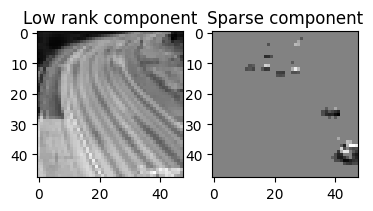

In [5]:
# chose which frame to display
frame = 35

plt.figure()
plt.subplot(1,3,1)
plt.imshow(L[frame, :,: ],cmap='gray')
plt.title('Low rank component')
plt.subplot(1,3,2)
plt.imshow(S[frame, :,:],cmap='gray')
plt.title('Sparse component')

In [6]:
# plt.plot(noize_history)

Now we can apply the flow alrorithm on the sparse matrix S

In [7]:
# Define the parameters for the flow algorithm
rho = S  # Sparse component
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = rho.shape[0]  # Number of frames in the video (put 1 if you have 2 frames)

# Apply the flow algorithm
start = time.time()
velocity_field = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)
end = time.time()
print('Time: ', end-start)

Time:  173.42294073104858


We can now visualize the result by ploting the magnitude of the output velocity field

In [8]:
# Frame to display
frame = 35

In [9]:
# Compute the speed magnitude of the velocity field at each pixel on each frame
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.linalg.norm(velocity_field[t, x, y, :])

In [10]:
# Images are upside down, so we need to flip them
speed_magnitude_frame = speed_magnitude[frame, :, :]
speed_magnitude_frame = np.flipud(speed_magnitude_frame)
original_frame = np.flipud(video[frame, :, :])

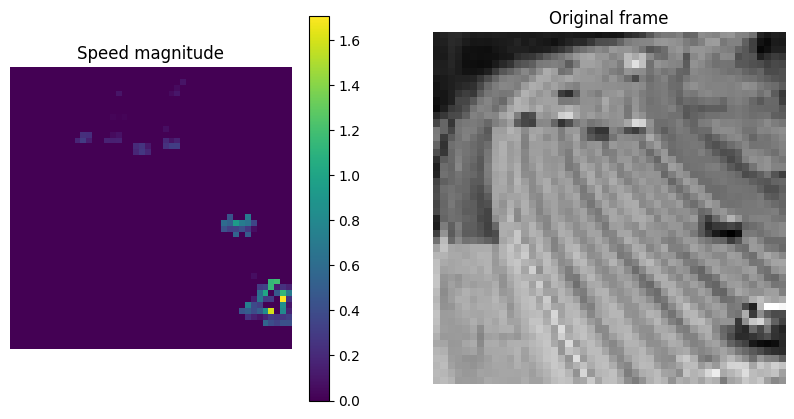

In [11]:
# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()
#plt.quiver(velocity_field[frame, :, :, 0], velocity_field[frame, :, :, 1], color='r')
# sorties en video

In [12]:
from makeVideo import makeVideo
makeVideo(speed_magnitude, "speed_magnitude.mp4", 5,True)

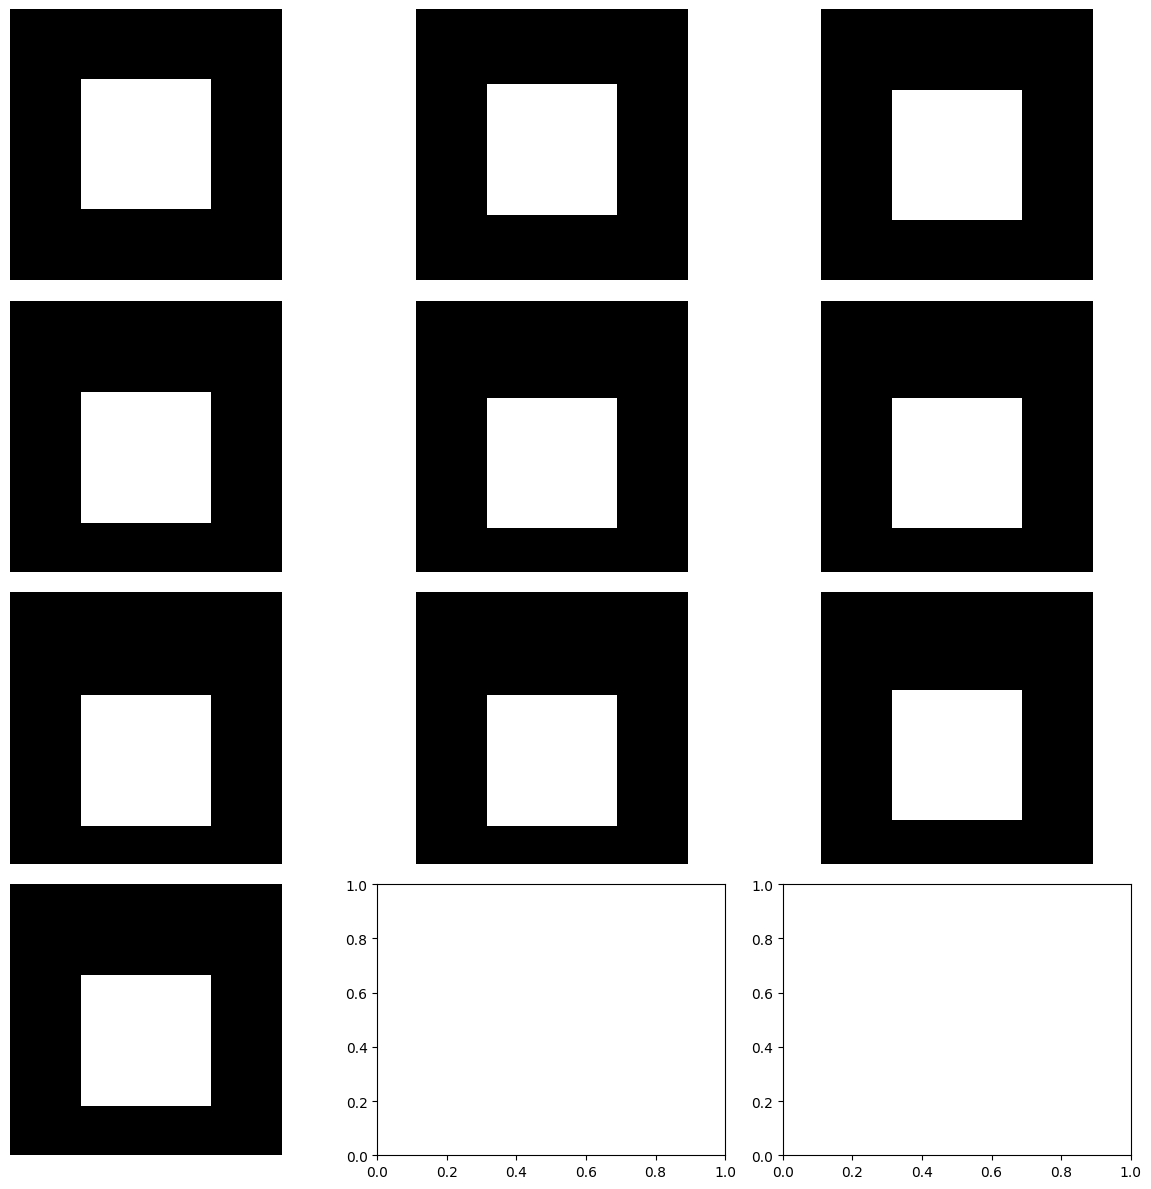

In [1]:
# Generate synthetic video
from generateImages import generateImageSequence

images = generateImageSequence(50, 50, "sine", 51 )

import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
rows = 4
cols = 3

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over the first 10 images and plot them
for i in range(10):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()




In [2]:
import numpy as np
from goDec import godec
from makeVideo import makeVideo
syntheticCube = np.array(images)
makeVideo(syntheticCube, "synthetic_video11.mp4", 5, False)
print(syntheticCube.shape)
print(np.max(syntheticCube))

# Chosing the parameters for GoDec
r = 2
k = 80*len(syntheticCube) # Equivalent to 20 active pixels per frame
print("k",k)
epsilon = 0.01
q = 3
L, S, W, error_history = godec(syntheticCube, 2,k,q,10,0.01)

(51, 50, 50)
1.0
k 4080
iter:  1 error:  0.08765252082170931
iter:  2 error:  0.08765252082170959
iter:  3 error:  0.08765252082170762
iter:  4 error:  0.08765252082170692
iter:  5 error:  0.08765252082170753
iter:  6 error:  0.08765252082170655
iter:  7 error:  0.08765252082170588
iter:  8 error:  0.08765252082170619
iter:  9 error:  0.08765252082170263
iter:  10 error:  0.08765252082170262


iter:  1 error:  0.09917415200485064
iter:  2 error:  0.0991741520048506
iter:  3 error:  0.09917415200485061
iter:  4 error:  0.09917415200485062
iter:  5 error:  0.09917415200485061
iter:  6 error:  0.09917415200485064
iter:  7 error:  0.09917415200484228
iter:  8 error:  0.09917415200484227
iter:  9 error:  0.09917415200484214
iter:  10 error:  0.09917415200484214


Text(0.5, 1.0, 'Sparse component')

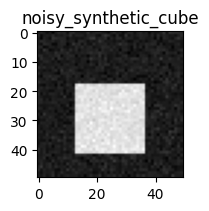

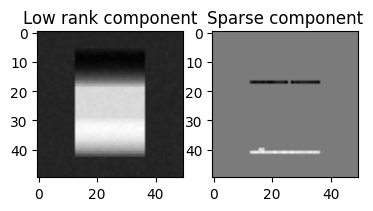

In [33]:
import numpy as np

# Add Gaussian noise to the synthetic cube
noise_std = 0.05 
noisy_synthetic_cube = syntheticCube + np.random.normal(0, noise_std, syntheticCube.shape)
L_noiy, S_noiy, W_noiy, error_history_noiy = godec(noisy_synthetic_cube,r,k,q,10,0.01)


frame = 34
plt.figure()
plt.subplot(1,3,1)
plt.imshow(noisy_synthetic_cube[frame, :,:],cmap='gray')
plt.title('noisy_synthetic_cube')
plt.figure()
plt.subplot(1,3,2)
plt.imshow(L[frame, :,:],cmap='gray')
plt.title('Low rank component')
plt.subplot(1,3,3)
plt.imshow(S[frame , :,:],cmap='gray')
plt.title('Sparse component')


In [23]:
# Applying the flow algorithm
from flowAlgorithm import flow_algorithm
rho = noisy_synthetic_cube  # Sparse component
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = rho.shape[0]  # Number of frames in the video (put 1 if you have 2 frames)

# Apply the flow algorithm
velocity_field = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)

C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm.py:24: RuntimeWarning: overflow encountered in double_scalars
  f_eq = omega[i] * rho_xy_t * (1 + 3*np.dot(epsilon[i], v_n_xy_t + (9/2.0)*np.dot(epsilon[i], v_n_xy_t)**2-1.5*np.linalg.norm(v_n_xy_t)**2))  # Calculate equilibrium distribution
C:\Users\dell\Documents\GitHub\LLBMOF-project\flowAlgorithm.py:24: RuntimeWarning: invalid value encountered in subtract
  f_eq = omega[i] * rho_xy_t * (1 + 3*np.dot(epsilon[i], v_n_xy_t + (9/2.0)*np.dot(epsilon[i], v_n_xy_t)**2-1.5*np.linalg.norm(v_n_xy_t)**2))  # Calculate equilibrium distribution


In [34]:
rho = S_noiy  # Sparse component
N = 5  # Number of correction cycles
omega_fr = 0.1  # Relaxation frequency
omega_tilde = 0.1  # Correction rate
nbFrames = rho.shape[0]  # Number of frames in the video (put 1 if you have 2 frames)

# Apply the flow algorithm
velocity_field_Dec = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)

In [30]:
x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
print(x.shape)
print(y.shape)

(10, 10)
(10, 10)


1.0


C:\Users\Norma\AppData\Local\Temp\ipykernel_25444\3157863634.py:6: RuntimeWarning: overflow encountered in scalar power
  speed_magnitude[t, x, y] = np.sqrt( (velocity_field[t, x, y, 0])**2 + (velocity_field[t, x, y, 1])**2)


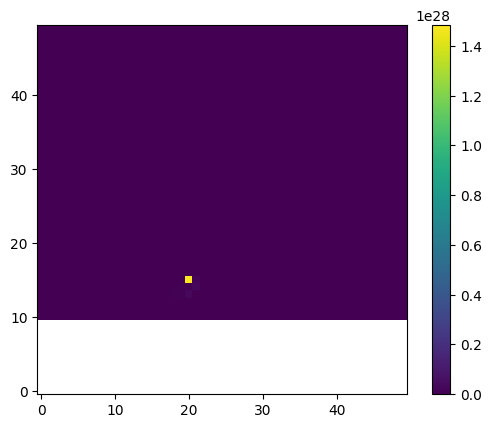

In [31]:
print(np.linalg.norm(np.array([1,0]),axis=0))
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.sqrt( (velocity_field[t, x, y, 0])**2 + (velocity_field[t, x, y, 1])**2)
frame = 35
plt.imshow(speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()



1.0


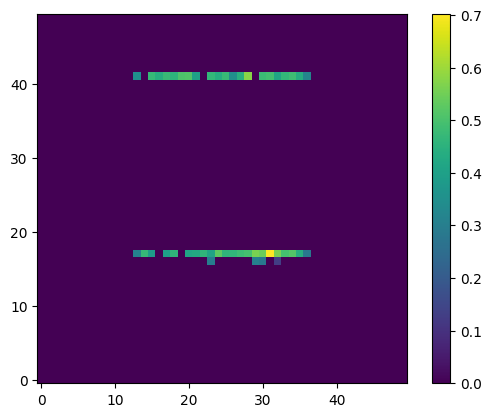

In [36]:
print(np.linalg.norm(np.array([1,0]),axis=0))
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.sqrt( (velocity_field_Dec[t, x, y, 0])**2 + (velocity_field_Dec[t, x, y, 1])**2)
frame = 35
plt.imshow(speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()



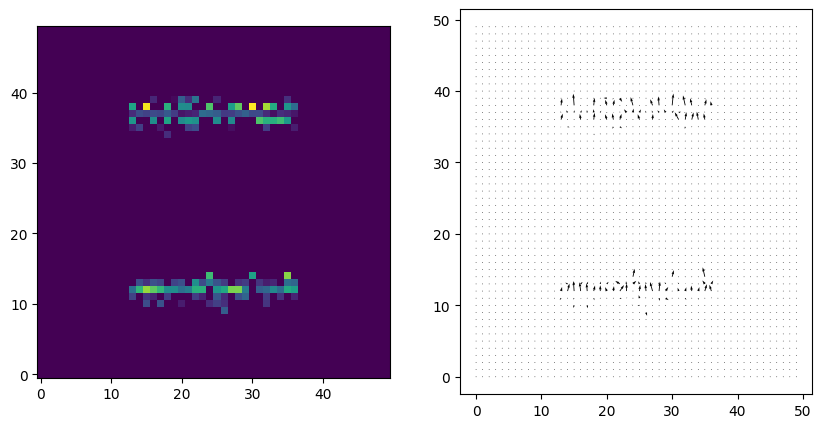

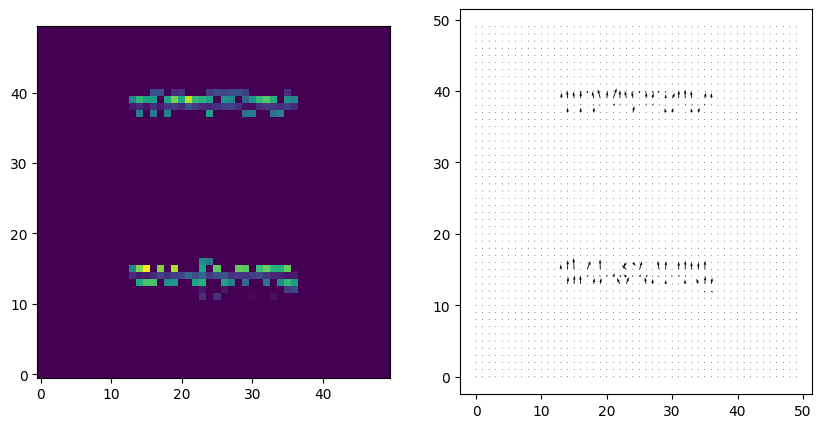

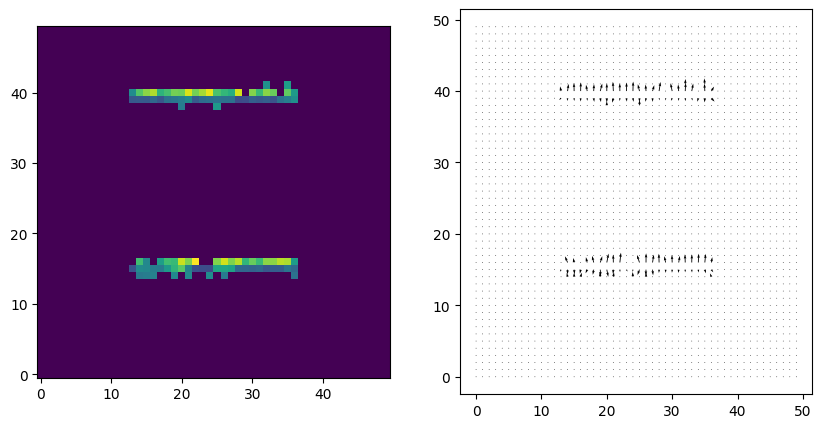

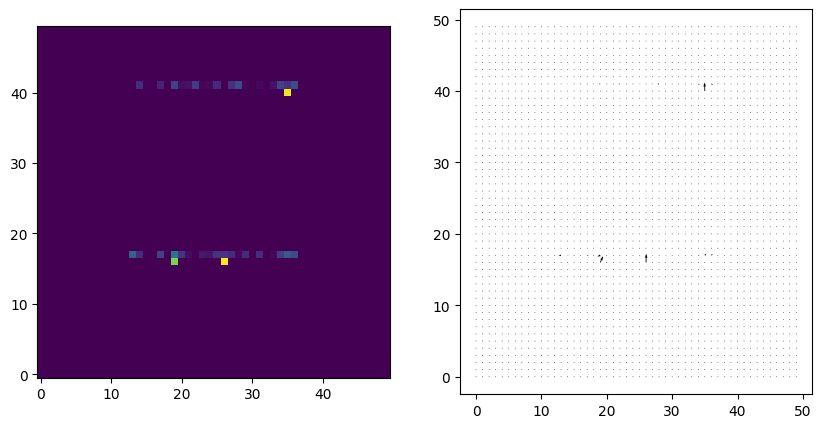

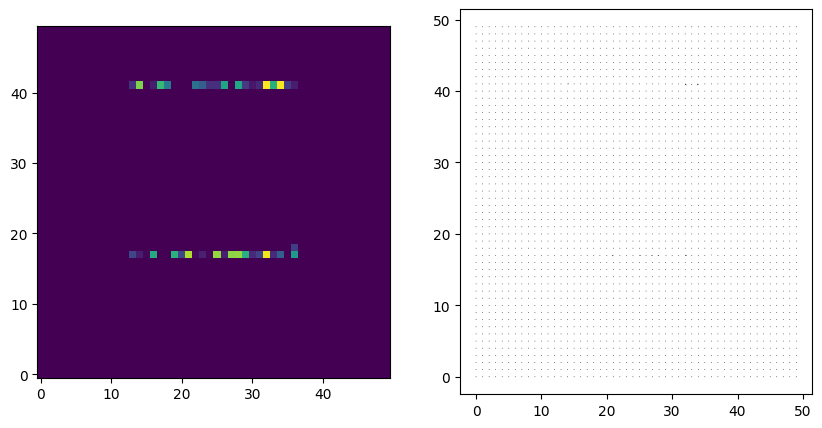

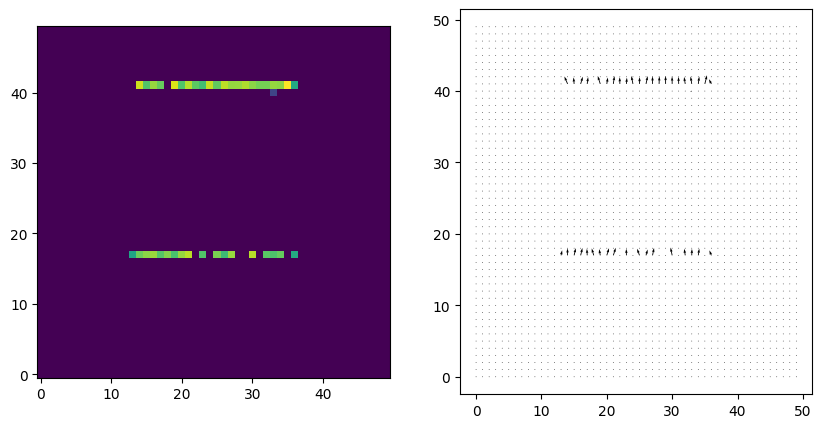

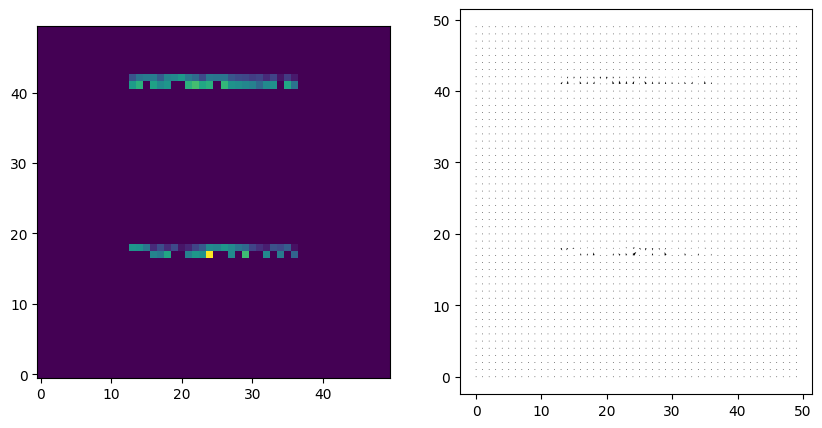

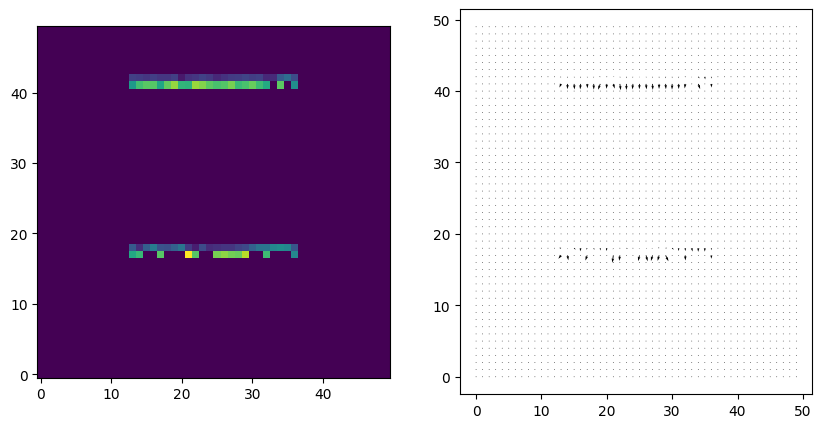

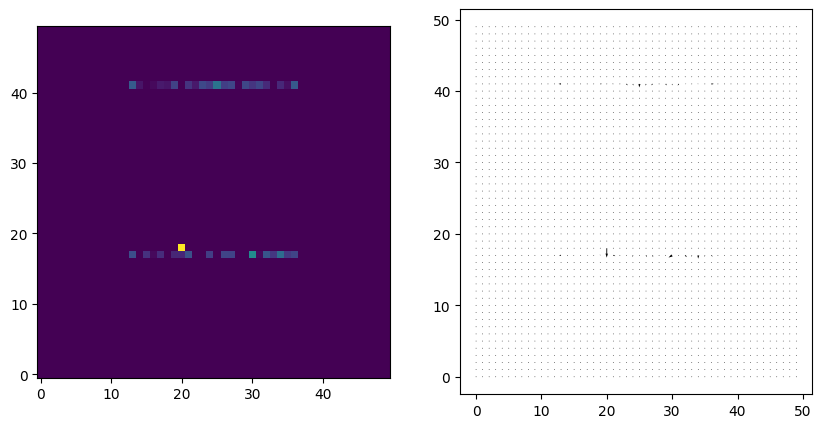

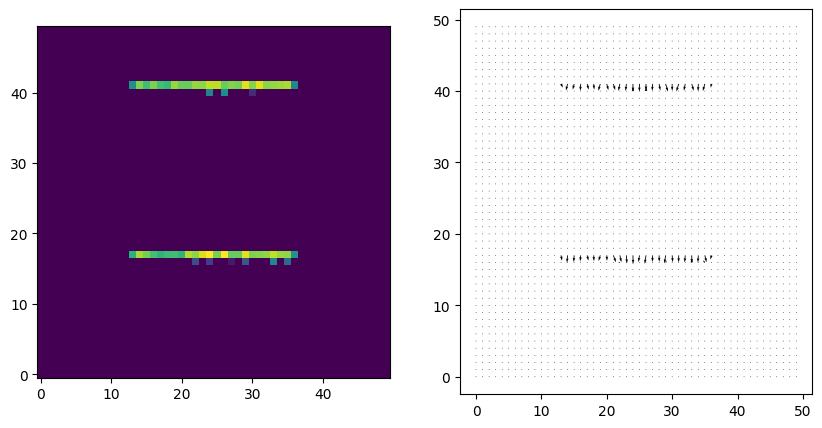

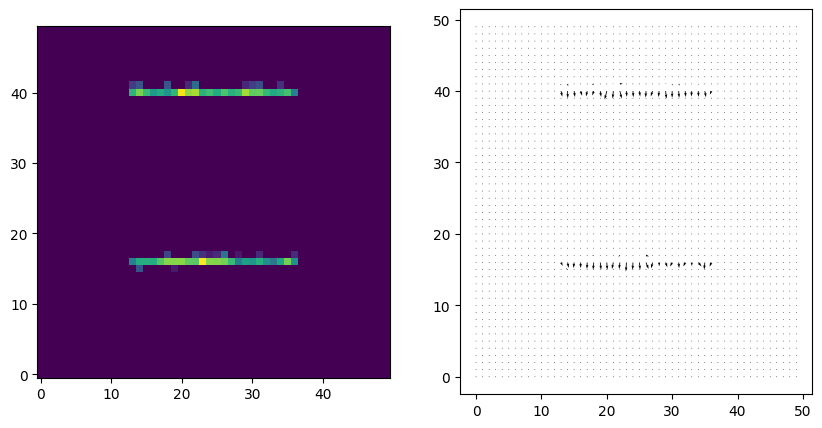

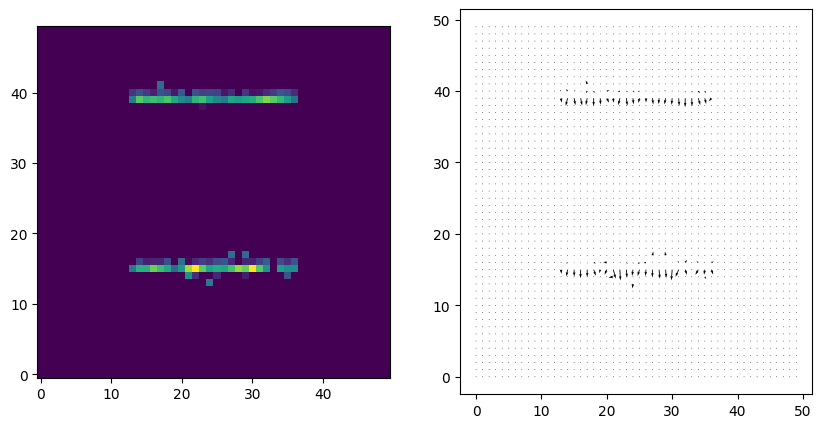

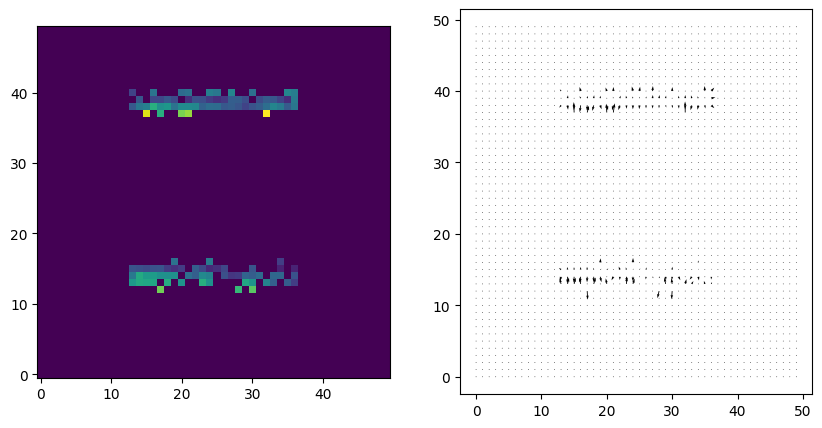

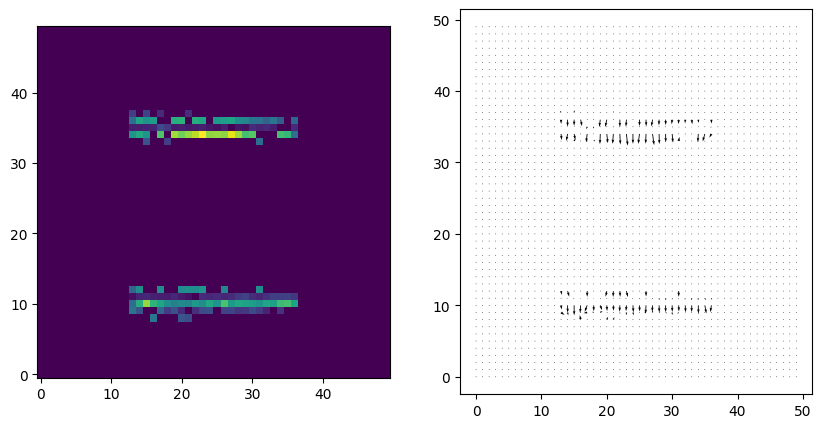

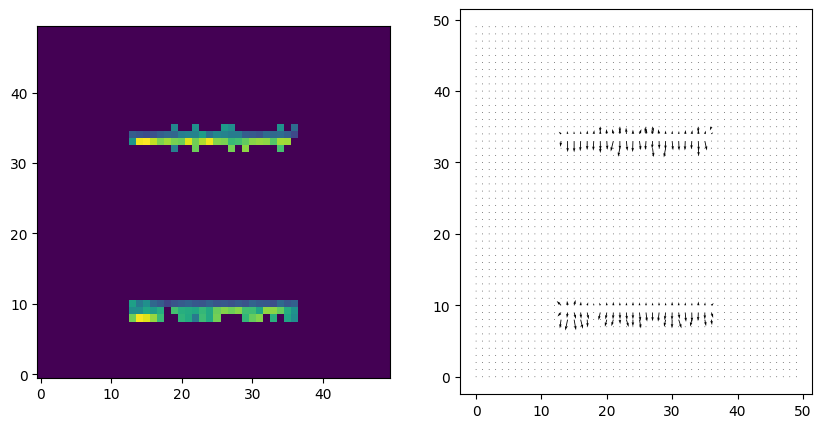

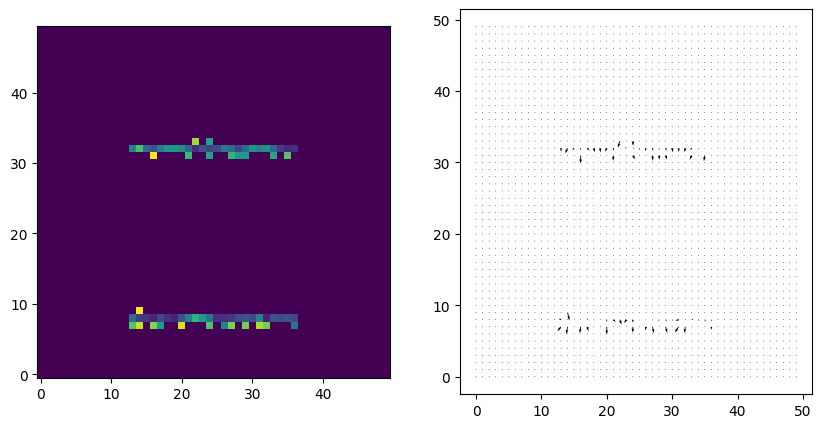

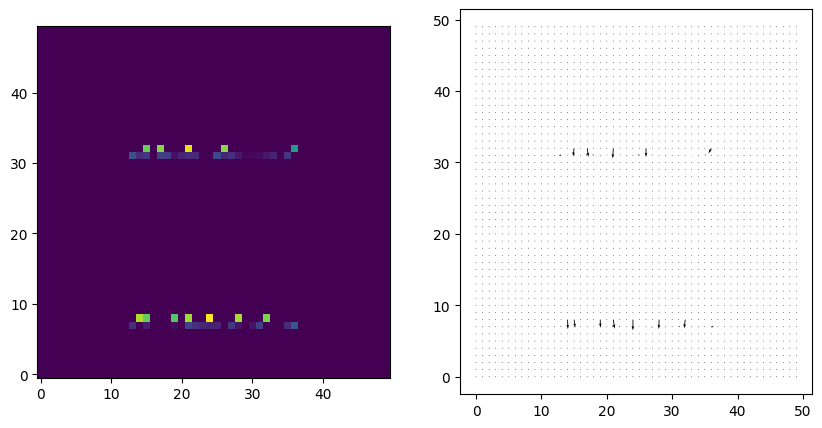

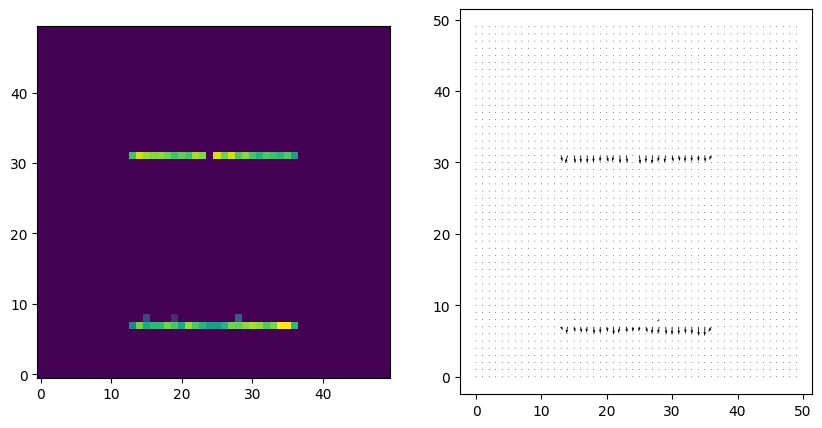

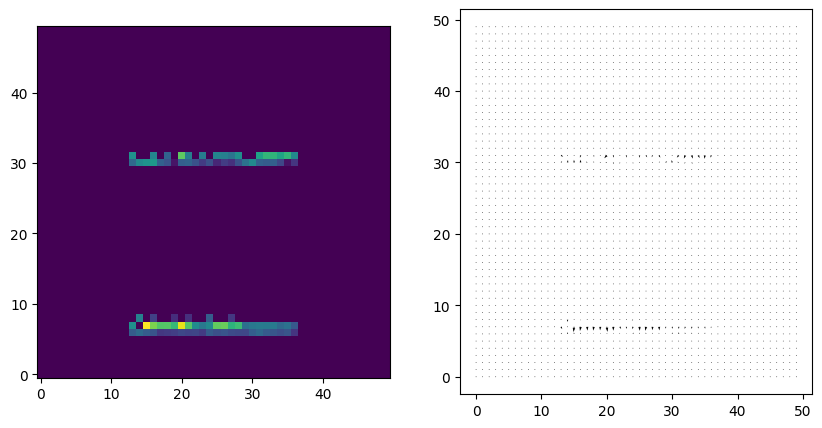

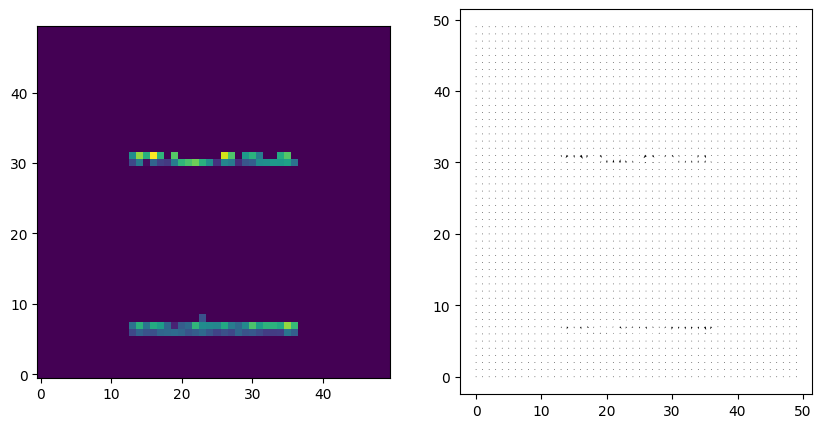

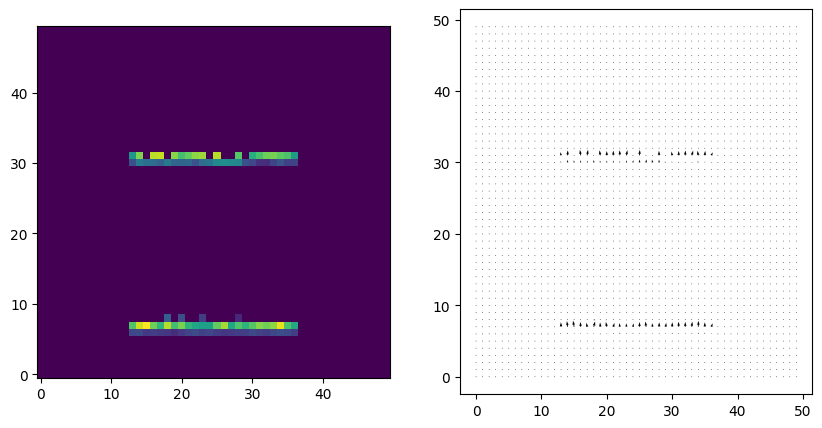

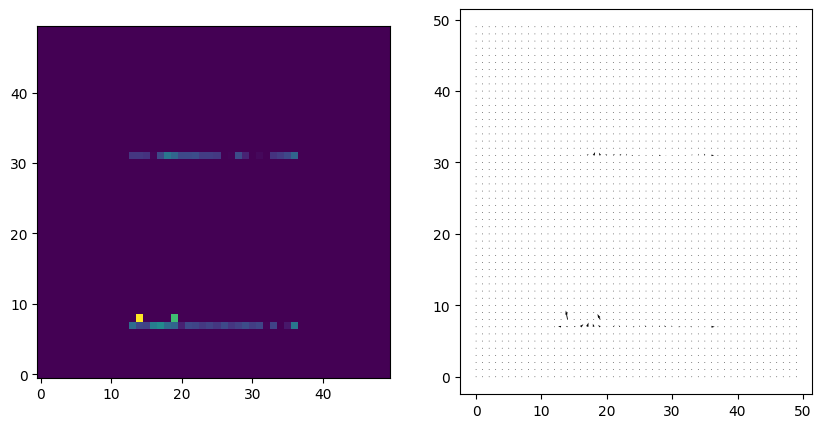

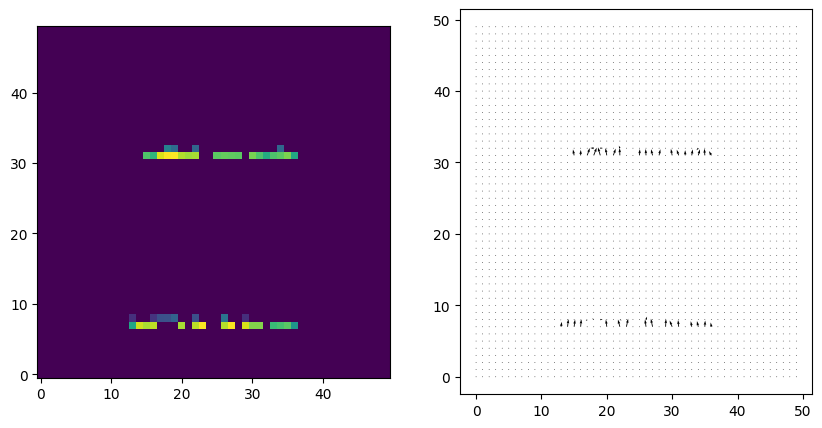

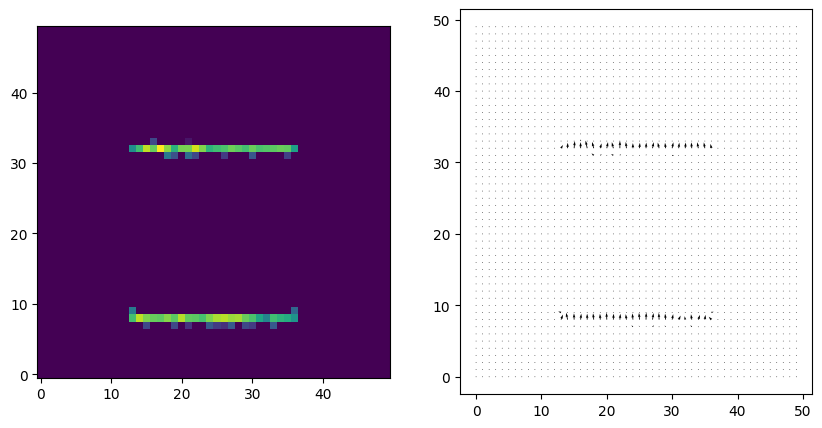

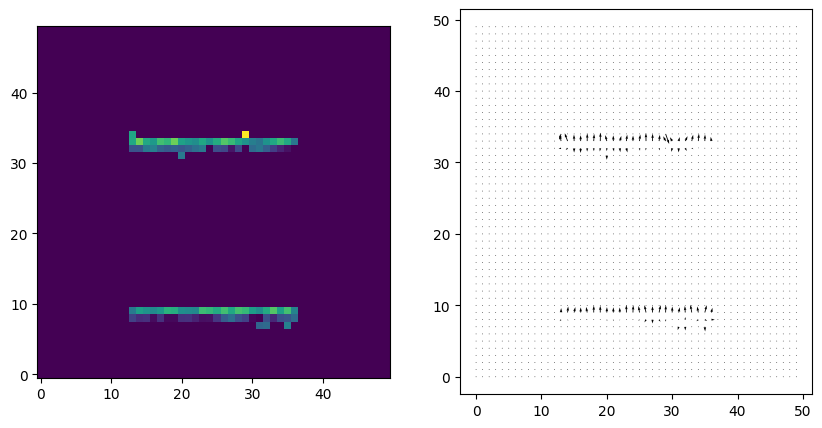

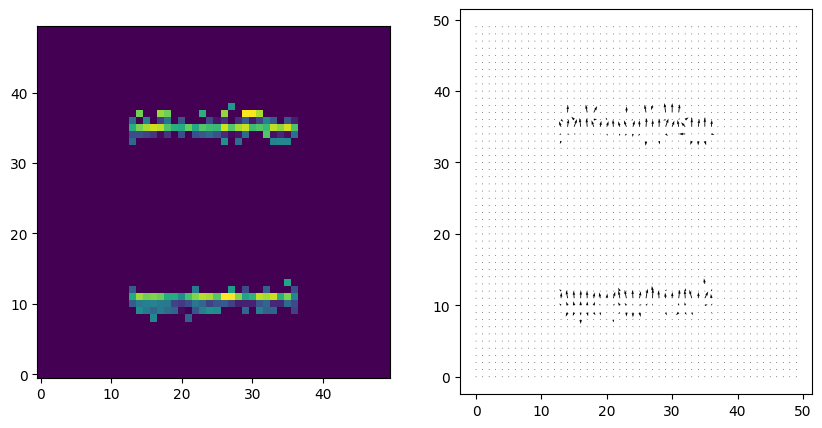

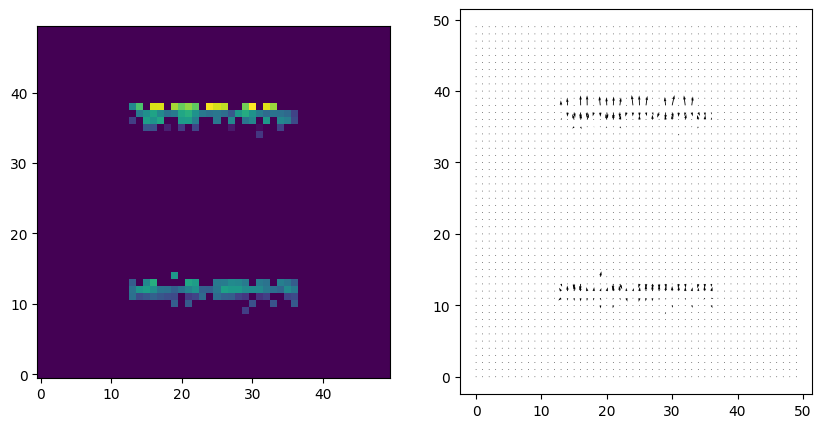

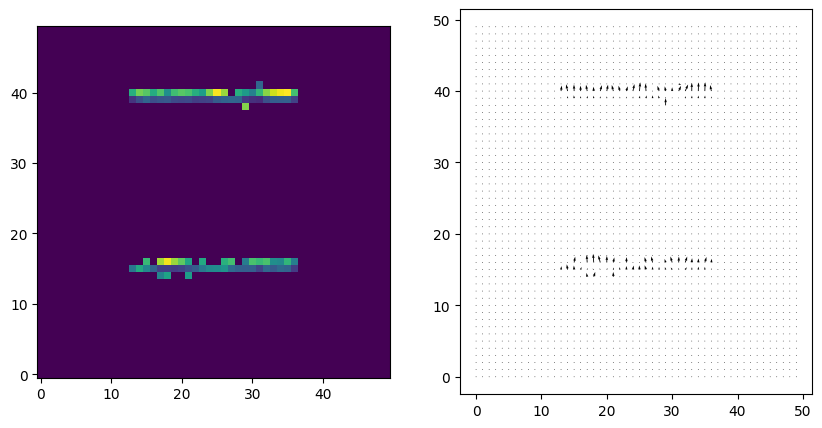

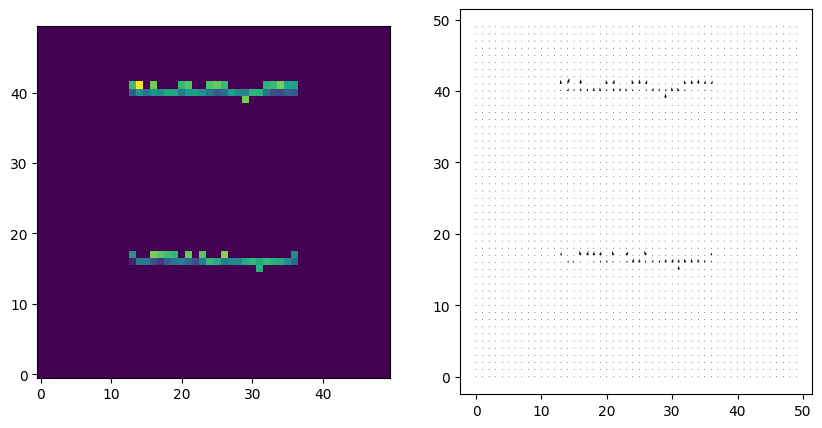

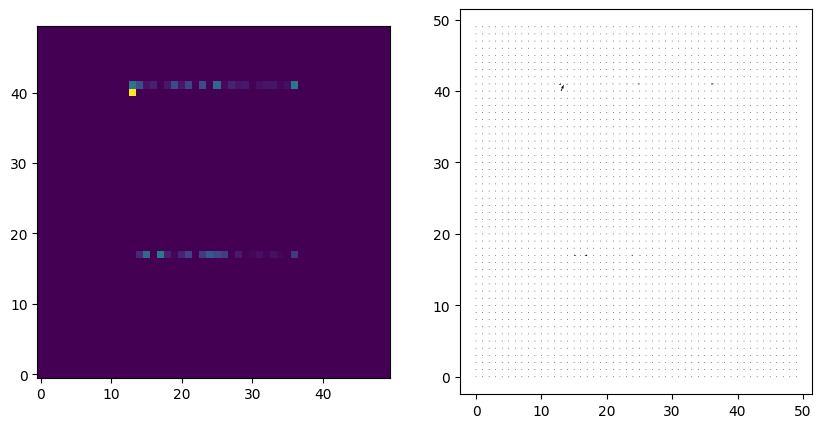

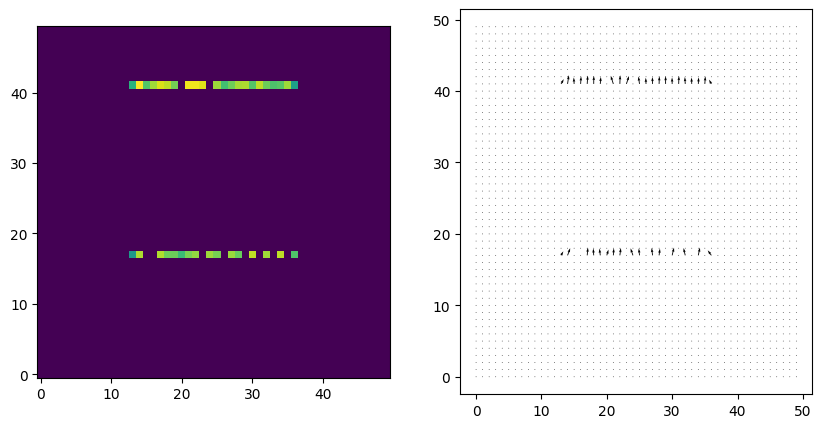

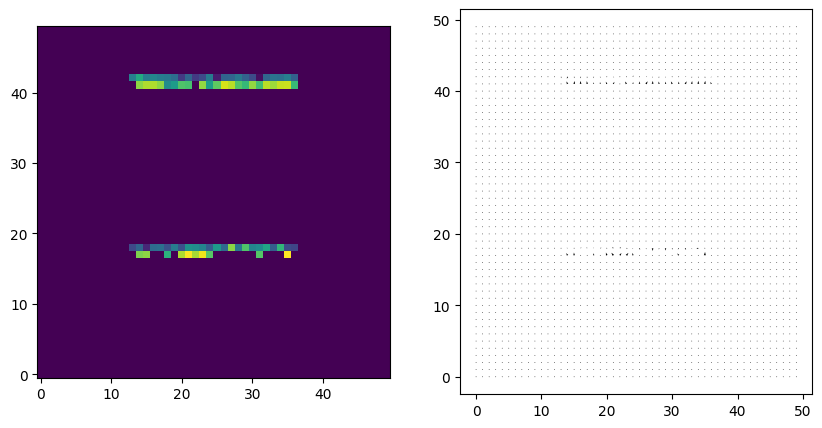

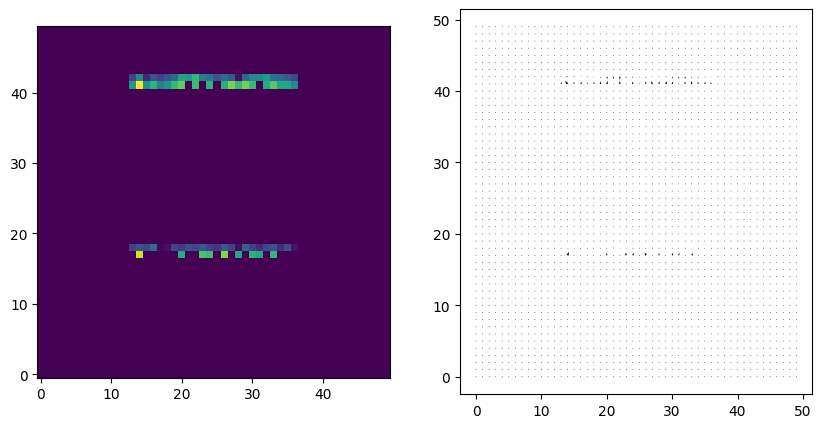

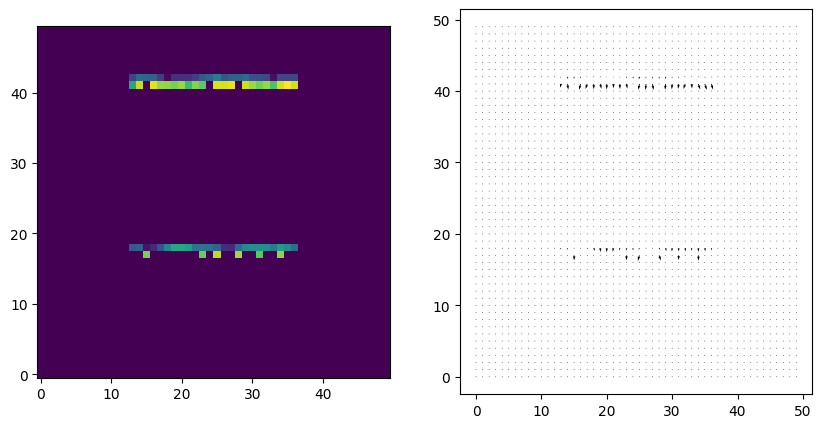

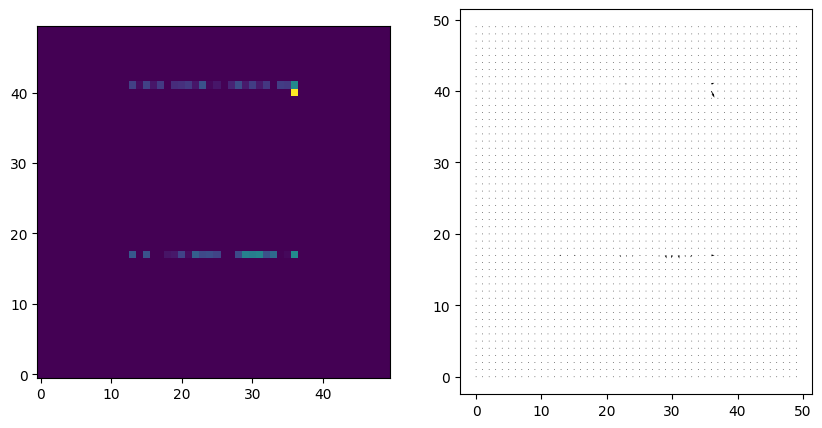

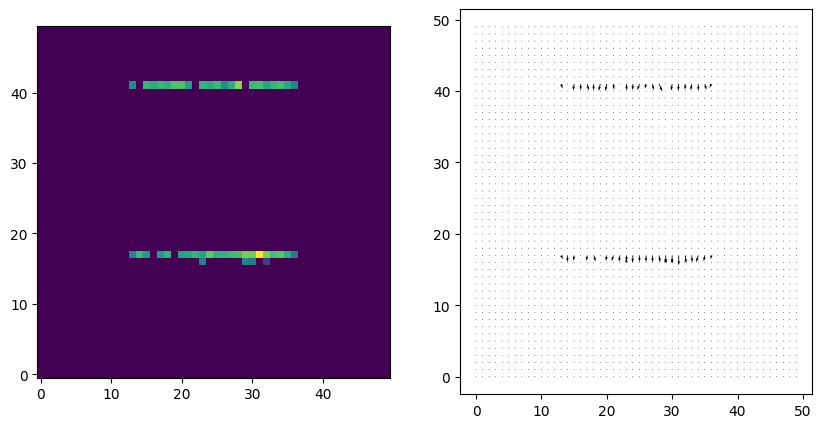

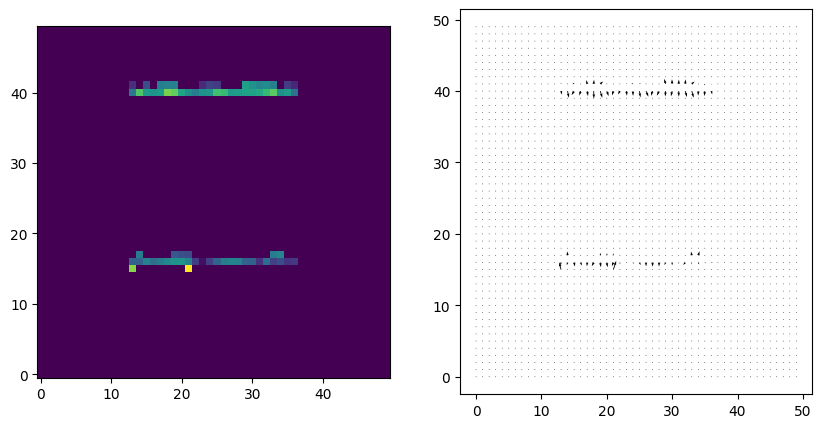

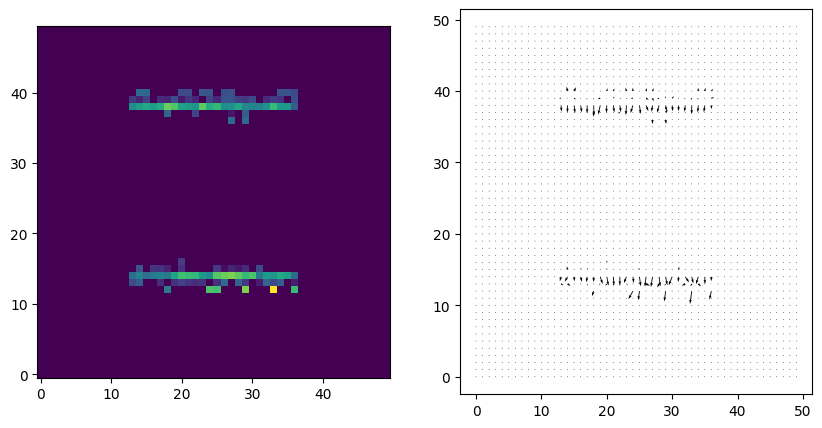

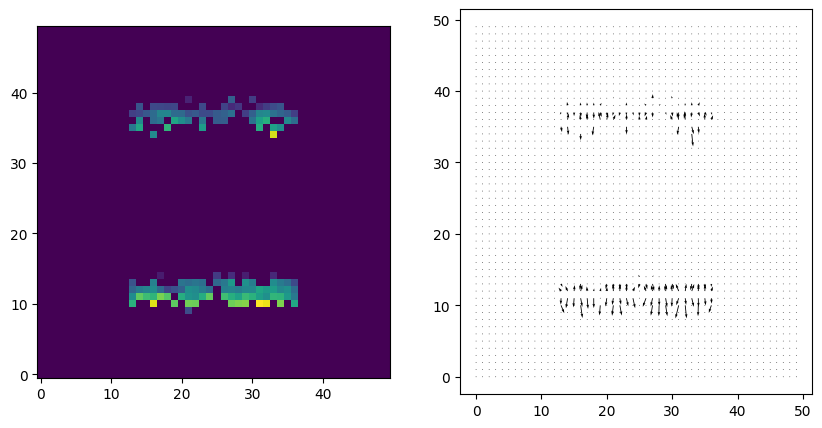

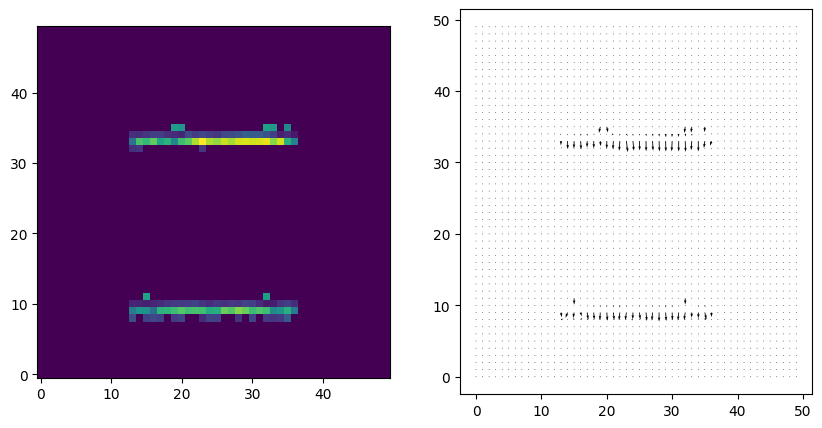

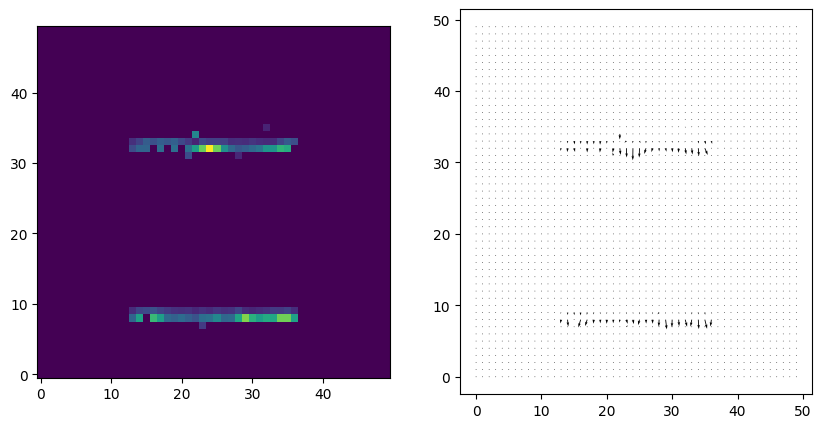

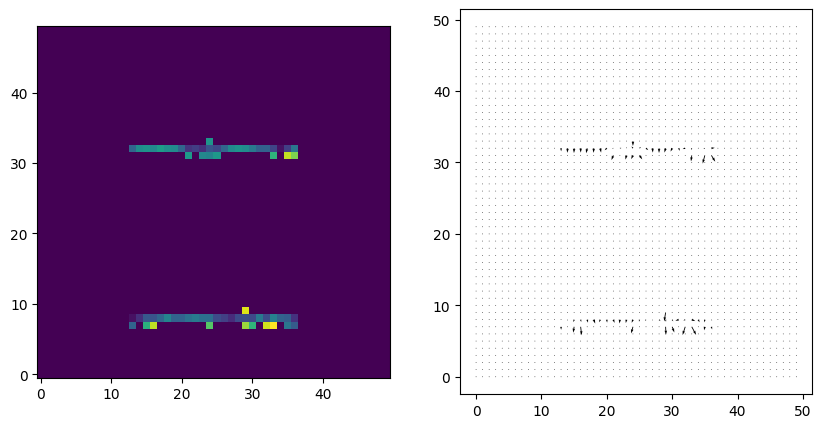

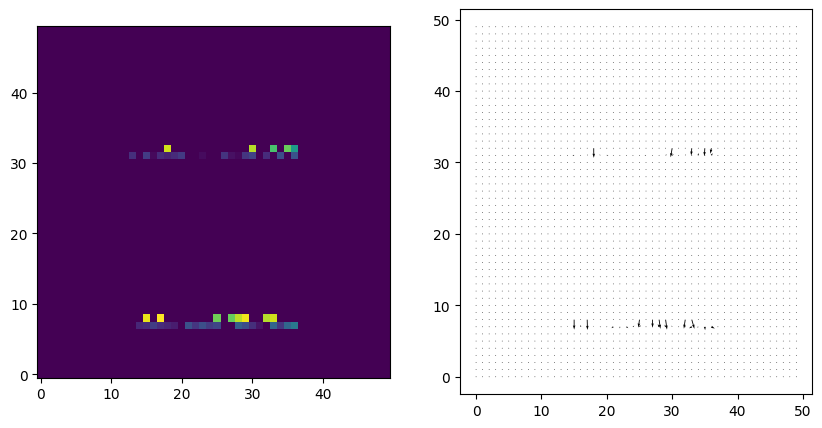

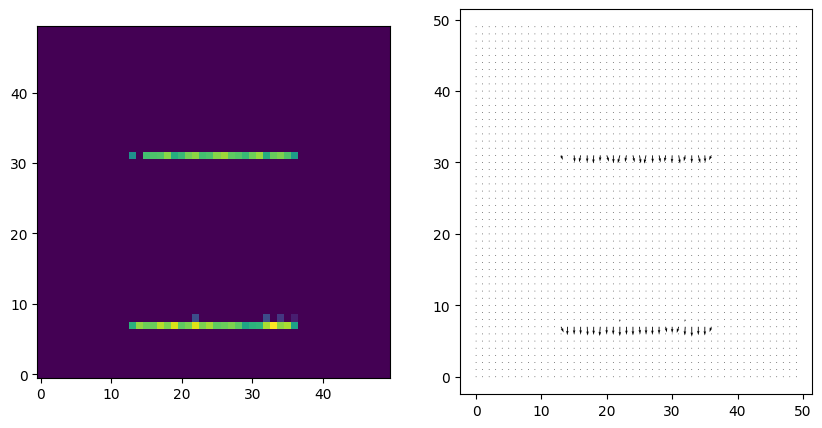

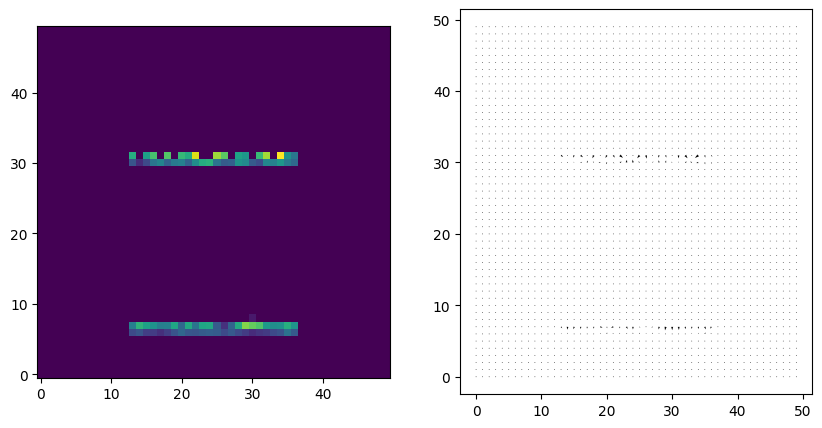

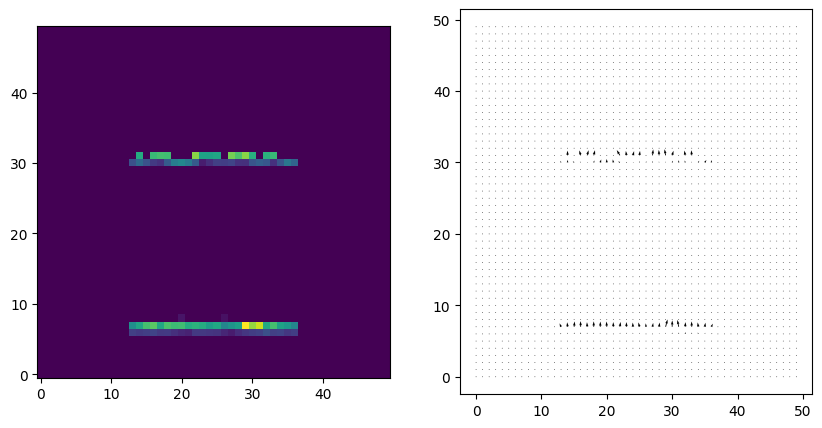

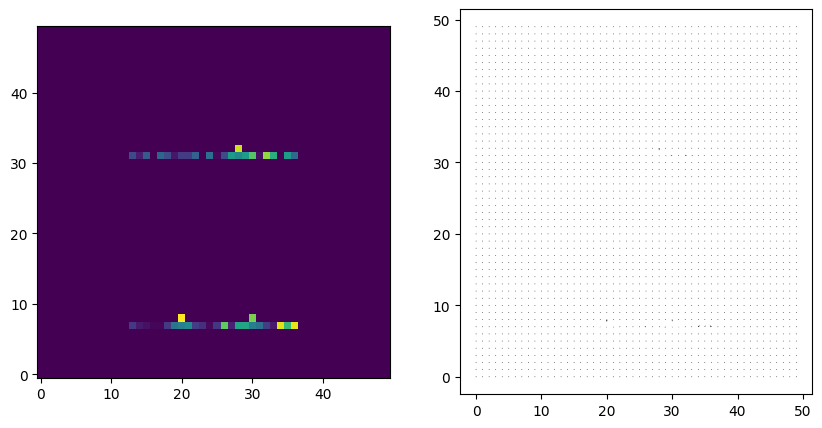

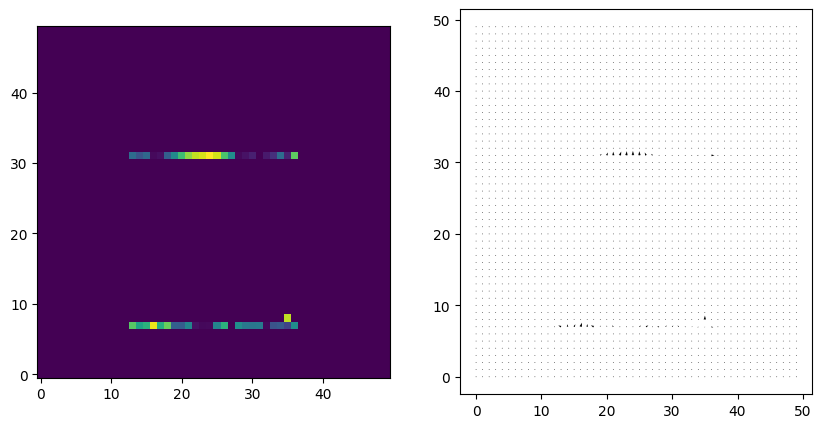

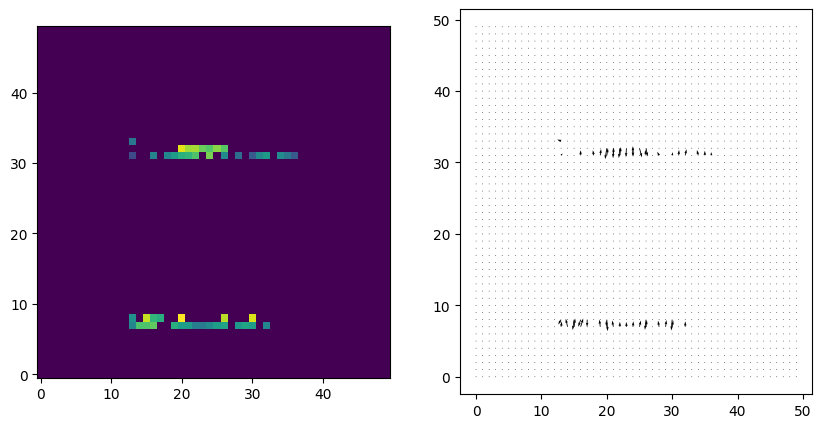

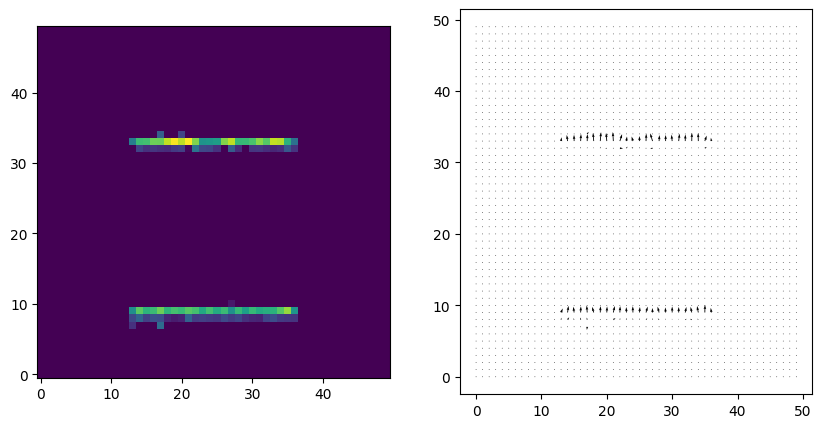

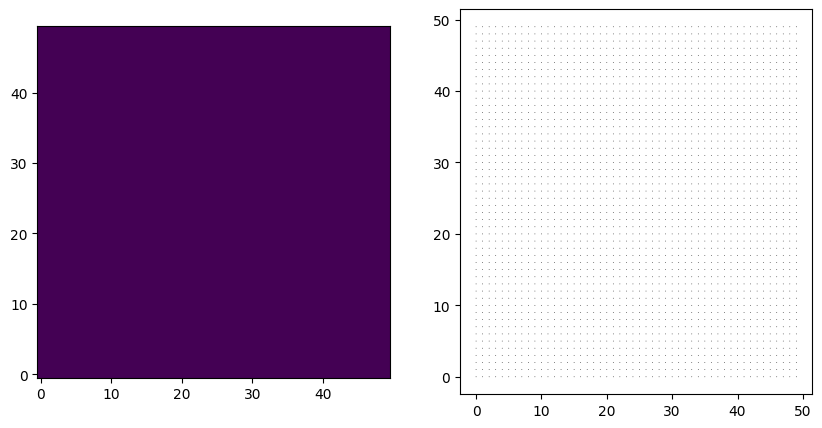

In [37]:
frame_index =10
for frame_index in range(len(velocity_field_Dec)):
    selected_frame = velocity_field_Dec[frame_index]

    # Extract the x and y components of the velocity vectors
    x_component = selected_frame[:, :, 1]
    y_component = selected_frame[:, :, 0]

    # Create a grid of coordinates for the quiver plot
    x, y = np.meshgrid(np.arange(selected_frame.shape[1]), np.arange(selected_frame.shape[0]))

    # Plot the velocity vectors using quiver plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(speed_magnitude[frame_index, :, :], cmap='viridis', origin='lower')
    plt.subplot(1, 2, 2)
    plt.quiver(x, y, x_component, y_component, angles='xy', scale_units='xy', scale=0.5)
    plt.savefig("Output/velocityField/velocity_"+str(frame_index) + ".png")
    plt.show()

In [ ]:
import os
import cv2
import numpy as np

# Define the path to the directory containing the images
image_dir = "Output/velocityField/"

# Define the number of images
num_images = 51

# Create an empty cube array to store the images
image_cube = np.zeros((num_images, 500, 1000), dtype=np.float64)

# Iterate over the image files and load them into the cube array
for i in range(num_images):
    # Construct the image file path
    image_path = os.path.join(image_dir, f"velocity_{i}.png")
    
    # Read the image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Store the image array in the cube array
    image_cube[i] = image

# Print the shape of the image cube
print("Image cube shape:", image_cube.shape)
image_cube = image_cube/np.max(image_cube)
image_cube = np.array(image_cube)
    

Image cube shape: (51, 500, 1000)


In [ ]:
import cv2
import os

def images_to_video(image_paths, output_video_path, fps=5):
    """
    Converts a list of images to a video file.

    Parameters:
    - image_paths: List of paths to the images.
    - output_video_path: Path for the output video file.
    - fps: Frames per second for the output video.
    """
    # Check if the image list is empty
    if not image_paths:
        raise ValueError("The list of image paths is empty.")
    
    # Read the first image to determine the video size
    frame = cv2.imread(image_paths[0])
    if frame is None:
        raise IOError(f"Error reading the first image: {image_paths[0]}")
    
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image_path in image_paths:
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Warning: Skipping image {image_path} due to read error.")
            continue
        out.write(frame)  # Write the frame to the video

    # Release everything when the job is finished
    out.release()
    print(f"Video saved to {output_video_path}")

# Example usage:
image_paths = [] # Add your image paths here
for i in range(51):
    image_paths.append("Output/velocityField/velocity_"+str(i) + ".png")
output_video_path = './Output/output_video.mp4'
images_to_video(image_paths, output_video_path, fps=5)


Video saved to ./Output/output_video.mp4


In [ ]:
def flow_algorithm_with_correction(rho_real, rho_doubled, N, omega_fr, omega_tilde, nbFrames):
    velocity_field_real = flow_algorithm(rho_real, N, omega_fr, omega_tilde, nbFrames)
    velocity_field_doubled = flow_algorithm(rho_doubled, N, omega_fr, omega_tilde, nbFrames)

    velocity_field_corrected = velocity_field_real - velocity_field_doubled

    return velocity_field_corrected
 

## Testing the accuracy of results

51
None


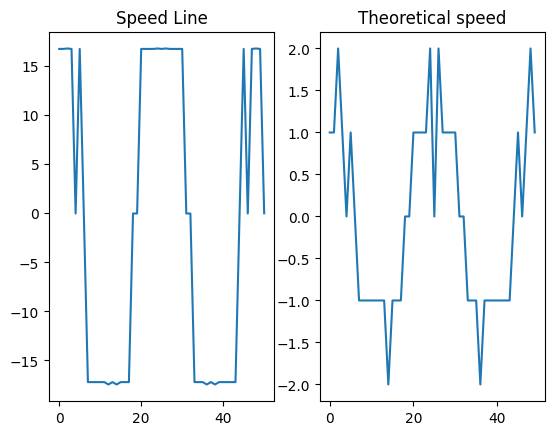

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a random column between 0 and length(speed_magnitude[0])
column = 35

speed_line = np.zeros(len(speed_magnitude))

frame = 35
x_velocity = velocity_field[frame, :, :, 0]
y_velocity = velocity_field[frame, :, :, 1]
field  = np.sum(x_velocity)
print(print(len(speed_line)))
for i in range(len(speed_line)):
    x_velocity = velocity_field[i, :, :, 0]
    y_velocity = velocity_field[i, :, :, 1]
    field  = np.sum(x_velocity)
    
    speed_line[i] = field
    # print(field)
    # direction = 1
    # if (abs(np.max(velocity_field[i , column, :,0]) )- abs( np.min(velocity_field[i , column, :,0])) < 0):
    #     direction = -1
    # speed_line[i] = direction *np.max(speed_magnitude[i, column, :])
    # index = np.argmax(speed_magnitude[i, column, :])

# Plot the speed magnitude of the velocity field at the chosen column
plt.subplot(1, 2, 1)
plt.plot(speed_line)
plt.title('Speed Line')

# Add a subplot of a cosine function
sequence = 50
x = np.arange(sequence)
y = np.zeros((sequence,1))
for i in range(sequence):
    y[i] = int(50 / 8 * np.sin(4 * np.pi * (i+1) / 51)) - int(50 / 8 * np.sin(4 * np.pi * i / 51))

plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.title('Theoretical speed')

plt.show()


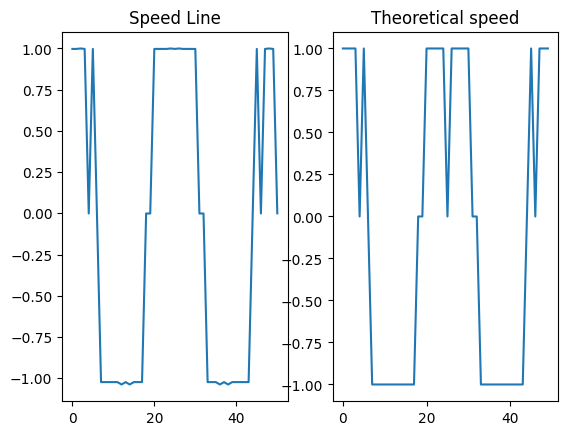

In [ ]:
# Divide by the maximum value to normalize the speed line
speed_line = speed_line / np.max(speed_line)

for i in range(len(y)):
    if y[i] <= -1:
        y[i] = -1
    if y[i] >= 1:
        y[i] = 1

# Plot the speed magnitude of the velocity field at the chosen column
plt.subplot(1, 2, 1)
plt.plot(speed_line)
plt.title('Speed Line')

# Add a subplot of a cosine function
plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.title('Theoretical speed')

plt.show()

In [ ]:
velocity_field_corrected = flow_algorithm_with_correction(rho_real, rho_doubled, N, omega_fr, omega_tilde, nb_frames)

NameError: name 'rho_real' is not defined

In [ ]:
def flow_algorithm_algorithm2(rho, N, omega_fr, omega_tilde, nbFrames):
    velocity_field_algorithm1 = flow_algorithm(rho, N, omega_fr, omega_tilde, nbFrames)  # Call original flow algorithm (Algorithm 1)
    rho_tilde = rho.copy()  # Copy the density array to work with

    # Apply the modification described in the remark
    for t in range(1, nbFrames):
        rho_tilde[t] = 2 * rho[t] - rho[t - 1]  # Consider twice the image at time t

    velocity_field_algorithm2 = flow_algorithm(rho_tilde, N, omega_fr, omega_tilde, nbFrames)  # Call original flow algorithm with modified input

    # Subtract the obtained velocity field of Algorithm 2 from Algorithm 1
    velocity_field_difference = velocity_field_algorithm1 - velocity_field_algorithm2

    return velocity_field_difference
velocity_field_corrected = flow_algorithm_algorithm2(rho, N, omega_fr, omega_tilde, nbFrames)

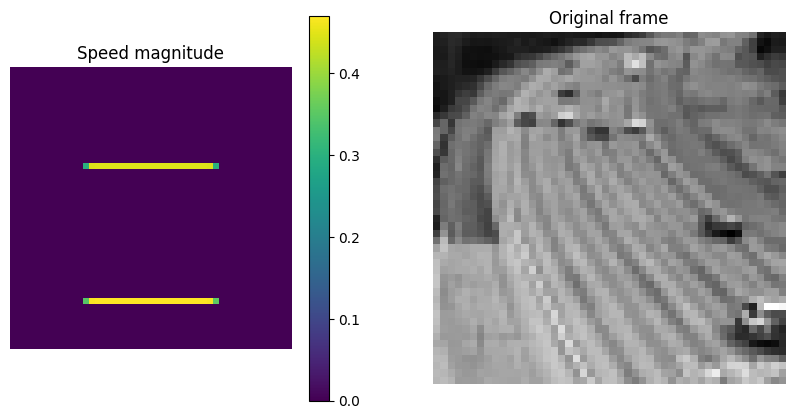

In [ ]:
# Compute the speed magnitude of the velocity field at each pixel on each frame
speed_magnitude = np.zeros((nbFrames, rho.shape[1], rho.shape[2])) 
for t in range(nbFrames-1):
    for x in range(rho.shape[1]):
        for y in range(rho.shape[2]):
            speed_magnitude[t, x, y] = np.linalg.norm(velocity_field[t, x, y, :])
            
speed_magnitude_frame = speed_magnitude[frame, :, :]
speed_magnitude_frame = np.flipud(speed_magnitude_frame)
original_frame = np.flipud(video[frame, :, :])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_magnitude_frame, cmap='viridis', origin='lower')
plt.axis('off')

plt.imsave("speed_magnitude.png",speed_magnitude[frame, :, :], cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Speed magnitude')
plt.subplot(1, 2, 2)
plt.imshow(original_frame, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Original frame')
plt.show()